# Anomaly Detection in Radiographs

>Bapuji Satyala

## Motivation

This project is driven by the urgent need to confront the pervasive impact of musculoskeletal conditions, which afflict over 1.7 billion individuals worldwide, causing substantial long-term pain and disability. With approximately 30 million emergency department visits annually and a rising trend, the burden is undeniable. Our motivation stems from the realization that in regions with limited access to skilled radiologists, timely and accurate diagnosis of these conditions remains a significant challenge, exacerbating healthcare disparities. Through this endeavor, we aspire to enhance healthcare access, particularly in underserved areas, by facilitating precise and timely diagnosis of musculoskeletal conditions.

## Dataset Description

MURA is a dataset of musculoskeletal radiographs consisting of 14,863 studies from 12,173 patients, with a total of 40,561 multi-view radiographic images. Each belongs to one of seven standard upper extremity radiographic study types: elbow, finger, forearm, hand, humerus, shoulder, and wrist. Each study was manually labeled as normal or abnormal by board-certified radiologists from the Stanford Hospital at the time of clinical radiographic interpretation in the diagnostic radiology environment between 2001 and 2012.

## Introduction

In this project, our objective build a convolutional neural network (CNN) to excel at detecting anomalies in radiographs. Specifically, we will focus on wrist images as our dataset to train the model for this task.

Importing the required libraries

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import re
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet169
from keras.metrics import Recall

## Loading the Data

The data structure of the input files is as following:

```

└─train {data subset}
│   └───XR_SHOULDER {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png
│       │               └───image3.png
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_SHOULDER {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png
                        └───...
```

As the training data and validation data is already defined, let us store the paths in their respective variables

In [42]:
train_img_paths_df = pd.read_csv("/content/drive/MyDrive" + "/MURA-v1.1/train_image_paths.csv",names = ["img_path"])

In [43]:
valid_img_paths_df=pd.read_csv("/content/drive/MyDrive"+ "/MURA-v1.1/valid_image_paths.csv",names = ["img_path"])

As the paths only contain the relative path and labels, let us extract the body part and the absolute path of image.

In [44]:
def preprocess_(path_df):
  path_df['body_part'] = path_df['img_path'].apply(lambda x: re.search(r'XR_(\w+)/', x).group(1).lower())
  path_df['label'] = path_df['img_path'].apply(lambda x: re.search(r'(positive|negative)', x).group(0))
  path_df['img_path'] = "/content/drive/MyDrive" + "/" + path_df['img_path']
  path_df['label'] = path_df['label'].apply(lambda x: "1" if x == 'positive' else "0")
  path_df = path_df[path_df['body_part'] == 'wrist']


  print(path_df.head(5))
  print()
  print(len(path_df))
  print()
  print(path_df['label'].value_counts())
  print()
  print(path_df['body_part'].value_counts())

  return path_df

Loading the training images

In [45]:
train_img_paths_df = preprocess_(train_img_paths_df)

                                                img_path body_part label
19688  /content/drive/MyDrive/MURA-v1.1/train/XR_WRIS...     wrist     1
19689  /content/drive/MyDrive/MURA-v1.1/train/XR_WRIS...     wrist     1
19690  /content/drive/MyDrive/MURA-v1.1/train/XR_WRIS...     wrist     1
19691  /content/drive/MyDrive/MURA-v1.1/train/XR_WRIS...     wrist     1
19692  /content/drive/MyDrive/MURA-v1.1/train/XR_WRIS...     wrist     1

9752

label
0    5765
1    3987
Name: count, dtype: int64

body_part
wrist    9752
Name: count, dtype: int64


Loadin the validation images

In [46]:
valid_img_paths_df = preprocess_(valid_img_paths_df)

                                            img_path body_part label
0  /content/drive/MyDrive/MURA-v1.1/valid/XR_WRIS...     wrist     1
1  /content/drive/MyDrive/MURA-v1.1/valid/XR_WRIS...     wrist     1
2  /content/drive/MyDrive/MURA-v1.1/valid/XR_WRIS...     wrist     1
3  /content/drive/MyDrive/MURA-v1.1/valid/XR_WRIS...     wrist     1
4  /content/drive/MyDrive/MURA-v1.1/valid/XR_WRIS...     wrist     1

659

label
0    364
1    295
Name: count, dtype: int64

body_part
wrist    659
Name: count, dtype: int64


**Let us split the 20% of the training data into testing data to test it later**

In [47]:
train_img_paths_df = train_img_paths_df.sample(frac=1).reset_index(drop=True)

# Split the shuffled DataFrame into train and test sets
train_img_paths_df, test_img_paths_df = train_test_split(train_img_paths_df, test_size=0.2, random_state=42)

## Exploratory Data Analysis

Let us look further in our trianing data

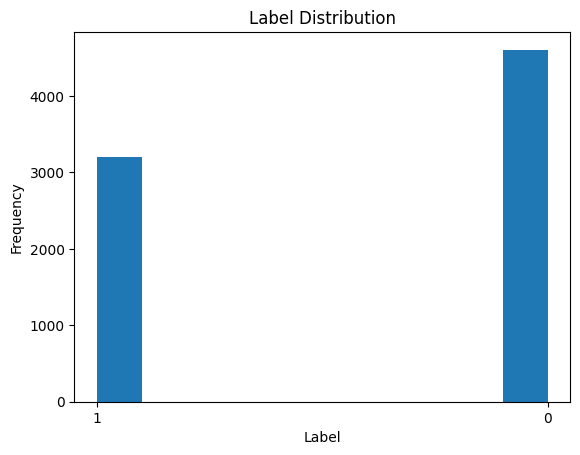

In [48]:
plt.hist(train_img_paths_df['label'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

We can see that we have equal distribution of normal and abnormal images and the classes are balanced

Let us look at a sample of Abnormal Images

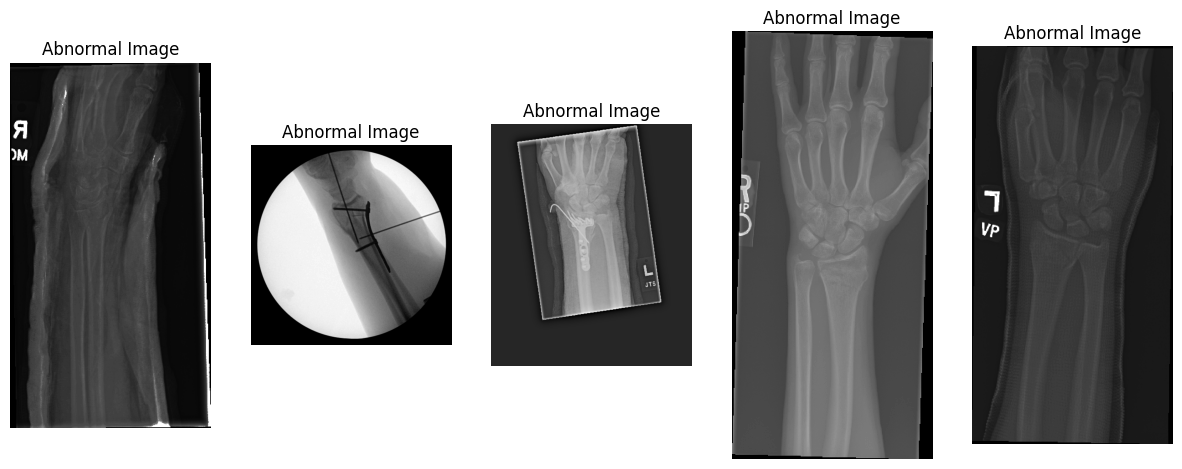

In [49]:
# Filter data where label is 1
label_1_data = train_img_paths_df[train_img_paths_df['label'] == '1']

# Display a sample of the filtered data
sample_images = label_1_data.sample(5)  # Adjust the number of samples as needed

# Plot the sample images
plt.figure(figsize=(15, 7))
for i, row in enumerate(sample_images.itertuples(), 1):
    image_path = row.img_path
    image = Image.open(image_path)
    plt.subplot(1, 5, i)
    plt.imshow(image,cmap="gray")
    plt.title("Abnormal Image")
    plt.axis('off')

plt.show()

By the above images, we could see that the images contain some kind of anamoly in them.

Let us look at a sample of normal images

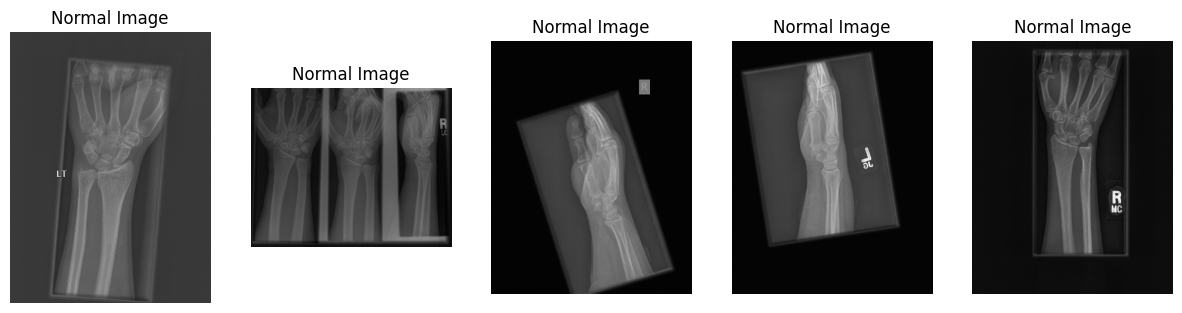

In [51]:
# Filter data where label is 1
label_1_data = train_img_paths_df[train_img_paths_df['label'] == '0']

# Display a sample of the filtered data
sample_images = label_1_data.sample(5)  # Adjust the number of samples as needed

# Plot the sample images
plt.figure(figsize=(15, 7))
for i, row in enumerate(sample_images.itertuples(), 1):
    image_path = row.img_path
    image = Image.open(image_path)
    plt.subplot(1, 5, i)
    plt.imshow(image,cmap="gray")
    plt.title("Normal Image")  # Extracting image filename for label
    plt.axis('off')

plt.show()

By the above images, we could see that they look normal without any anomalies

## Data Augmentation

The below code establishes a pipeline for image preprocessing and generation using Keras `ImageDataGenerator`. It starts by standardizing values to fall within the range of 0 to 1 for input images. Following that three distinct generators are generated for training, validation and testing datasets. These generators dynamically load images from DataFrame objects and pair them with corresponding labels. The images are resized to a dimension of 224x224 pixels and data is handled in batches of 32 while incorporating shuffling to introduce variability and prevent overfitting.


In [50]:
image_generator = ImageDataGenerator(rescale=1./255) # rescale 1./255 to normalize pixel values

training_generator = image_generator.\
    flow_from_dataframe(dataframe=train_img_paths_df,
                        directory=None,
                        x_col="img_path",
                        y_col="label",
                        target_size=(224,224),
                        class_mode="binary",
                        #color_mode="grayscale",
                        batch_size=32,
                        shuffle=True)

validation_generator = image_generator.\
    flow_from_dataframe(dataframe=valid_img_paths_df,
                        directory=None,
                        x_col="img_path",
                        y_col="label",
                        target_size=(224,224),
                        class_mode="binary",
                        #color_mode="grayscale",
                        batch_size=32,
                        shuffle=True)

test_generator = image_generator.\
    flow_from_dataframe(dataframe=test_img_paths_df,
                        directory=None,
                        x_col="img_path",
                        y_col="label",
                        target_size=(224,224),
                        class_mode="binary",
                        #color_mode="grayscale",
                        batch_size=32,
                        shuffle=True)

Found 7801 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.


In [52]:
images, labels = training_generator[0]
print(images.shape)

(32, 224, 224, 3)


## Modelling

Let us define the input shape for the image

In [53]:
input_shape = (224, 224, 3)

### Baseline Model

This initial model makes guesses without taking into account any characteristics or trends in the data. It categorizes outputs as either 0 or 1 based on numerical values above or below 0.5. By comparing these predictions with the actual labels in the validation set the models precision is determined. This precision serves as a starting point, for assessing advanced models that follow.


In [139]:
import random

class RandomClassifier(object):

    def predict(self) -> float:

        return random.random()

model = RandomClassifier()


labels = validation_generator.labels
preds = [model.predict() for _ in labels]

binary_preds = [1 if pred >= 0.5 else 0 for pred in preds]

# Calculate accuracy
accuracy = sum([1 if pred == label else 0 for pred, label in zip(binary_preds, labels)]) / len(labels)
print("Validation Accuracy:", accuracy)


# Calculate true positives (TP), false negatives (FN), and true negatives (TN)
TP = sum([1 if pred == 1 and label == 1 else 0 for pred, label in zip(binary_preds, labels)])
FN = sum([1 if pred == 0 and label == 1 else 0 for pred, label in zip(binary_preds, labels)])
TN = sum([1 if pred == 0 and label == 0 else 0 for pred, label in zip(binary_preds, labels)])

# Calculate recall
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print("Validation Recall:", recall)


Validation Accuracy: 0.48103186646433993
Validation Recall: 0.4915254237288136


### CNN

The architecture comprises a series of convolutional layers, progressively extracting features from input images with increasing complexity via filters of sizes 16, 32, 64, and 128. Employing a (3, 3) kernel size, (1, 1) stride, and "same" padding, each layer is enhanced with L2 regularization, ReLU activation, and batch normalization for stability. Max pooling layers with (2, 2) pool sizes and strides reduce spatial dimensions, followed by dropout layers to mitigate overfitting. The flattened feature maps are fed into dense layers, culminating in a final sigmoid-activated unit for binary classification. This architecture optimizes feature extraction, regularization, and classification for image tasks.

In [128]:
cnn_model = tf.keras.Sequential()

cnn_model.add(Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_regularizer="l2",
    dilation_rate=(1, 1),
    activation="relu",
    input_shape=input_shape
))

cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding="same"
))
cnn_model.add(Dropout(
    rate=0.25
))

cnn_model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_regularizer="l2",
    dilation_rate=(1, 1),
    activation="relu"
))

cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding="same"
))
cnn_model.add(Dropout(
    rate=0.25
))

cnn_model.add(Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_regularizer="l2",
    dilation_rate=(1, 1),
    activation="relu"
))

cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding="same"
))
cnn_model.add(Dropout(
    rate=0.25
))

cnn_model.add(Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_regularizer="l2",
    dilation_rate=(1, 1),
    activation="relu"
))

cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding="same"
))
cnn_model.add(Dropout(
    rate=0.25
))

cnn_model.add(Flatten())
cnn_model.add(Dense(
    units=128,
    kernel_regularizer="l2",
    activation="relu"
))
cnn_model.add(Dense(
    units=1,
    activation="sigmoid"
))


In [129]:
cnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_13 (Ba  (None, 224, 224, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 16)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_14 (Ba  (None, 112, 112, 32)    

The model is compiled using the Adam optimizer with a learning rate of 0.0001, binary cross-entropy loss function, and metrics including accuracy and recall. Adam optimization efficiently adjusts learning rates for each parameter, binary cross-entropy is well-suited for binary classification tasks, and including recall as a metric evaluates the model's ability to identify true positives among all actual positives.

In [130]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',Recall()])

Two key callbacks are defined for model training: ReduceLROnPlateau and EarlyStopping. ReduceLROnPlateau monitors validation loss and reduces the learning rate by a factor of 0.1 if no improvement is seen after 3 epochs, ensuring finer adjustments during training. EarlyStopping halts training when validation loss doesn't improve for 5 epochs, restoring the model's best weights to prevent overfitting.

In [131]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Fitting the model

In [132]:
cnn_history = cnn_model.fit(training_generator,
                    epochs=20,
                    verbose = 1,
                    validation_data=validation_generator,
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/20
244/244 [==============================] - 50s 194ms/step - loss: 4.4038 - accuracy: 0.6158 - recall_2: 0.4304 - val_loss: 4.2896 - val_accuracy: 0.5266 - val_recall_2: 0.0136 - lr: 1.0000e-04
Epoch 2/20
244/244 [==============================] - 47s 191ms/step - loss: 3.5869 - accuracy: 0.6768 - recall_2: 0.4917 - val_loss: 3.6377 - val_accuracy: 0.5630 - val_recall_2: 0.0407 - lr: 1.0000e-04
Epoch 3/20
244/244 [==============================] - 47s 192ms/step - loss: 2.9915 - accuracy: 0.6930 - recall_2: 0.5393 - val_loss: 2.9367 - val_accuracy: 0.6176 - val_recall_2: 0.1966 - lr: 1.0000e-04
Epoch 4/20
244/244 [==============================] - 48s 195ms/step - loss: 2.5112 - accuracy: 0.7112 - recall_2: 0.5662 - val_loss: 2.4747 - val_accuracy: 0.6449 - val_recall_2: 0.3322 - lr: 1.0000e-04
Epoch 5/20
244/244 [==============================] - 46s 190ms/step - loss: 2.1331 - accuracy: 0.7257 - recall_2: 0.5965 - val_loss: 2.1814 - val_accuracy: 0.5994 - val_recall_2: 0.26

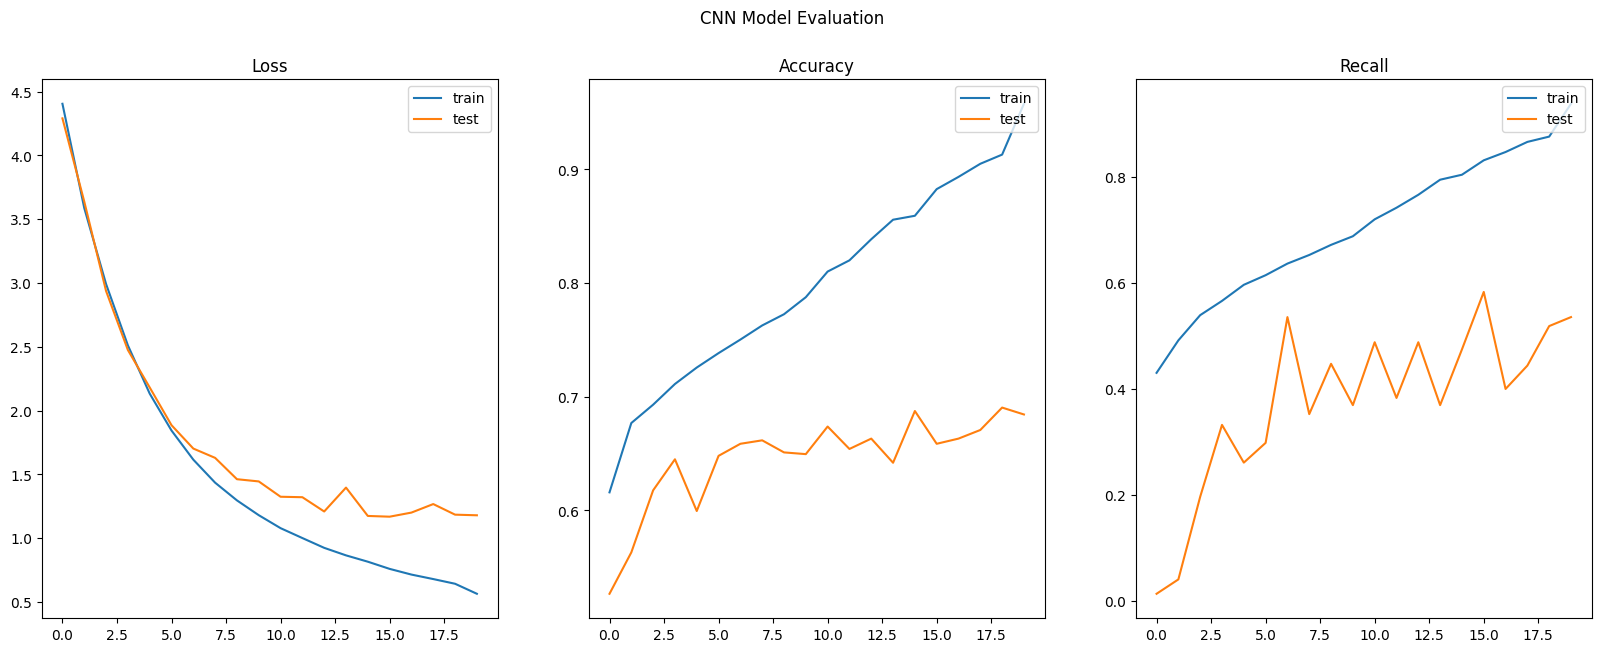

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('CNN Model Evaluation')


ax1.set_title('Loss')
ax1.plot(cnn_history.history['loss'])
ax1.plot(cnn_history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper right')

ax2.set_title('Accuracy')
ax2.plot(cnn_history.history['accuracy'])
ax2.plot(cnn_history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper right')

ax3.set_title('Recall')
ax3.plot(cnn_history.history['recall_2'])
ax3.plot(cnn_history.history['val_recall_2'])
ax3.legend(['train', 'test'], loc='upper right')

plt.show()


The graph reveals that the model achieves a relatively high training accuracy (95.78%) but struggles with generalization, evidenced by a lower validation accuracy (68.44%). While the training loss steadily decreases over epochs, the validation loss shows signs of plateauing, indicating that the model's performance is reaching a limit. Additionally, the recall metric, which measures the model's ability to capture positive instances, also exhibits limitations, particularly on the validation set. Despite some improvements in recall, it remains relatively low, indicating that the model is missing a considerable number of positive cases. These results suggest that the current architecture may not be sufficiently complex or optimized for the dataset, necessitating the exploration of more advanced architectures or optimization strategies to improve generalization performance and capture positive instances more effectively.

Considering the limitations seen in the CNN designs performance a shift to a DenseNet structure may bring about promising enhancements. DenseNet, recognized for its interconnection between layers supports the reuse of features smooth flow of gradients and efficient use of parameters. By incorporating DenseNets design into the neural network setup we expect to see improved feature transmission and more resilient representations. This design proves beneficial for datasets with restricted training examples like the one being studied since it encourages effective learning from existing data.

### CNN with DenseNet Architecture

The DenseNet architecture revolutionizes traditional CNN design by introducing dense connectivity between layers within dense blocks, where each layer receives direct input from all preceding layers. This unique connectivity pattern promotes efficient feature reuse, mitigates the vanishing gradient problem, and maintains parameter efficiency. By leveraging dense connections, DenseNet fosters deep architectures while minimizing the number of parameters required, facilitating more effective feature extraction and superior performance across a range of computer vision tasks, including image classification, object detection, and segmentation.

In the provided code snippet freezing the layers of the DenseNet169 model follows the concept of transfer learning, which's essential for effectively adapting pre trained models to new tasks. By keeping these trained layers non trainable the model retains valuable information stored in their weights from being exposed to a vast array of images, from ImageNet. This approach not protects against overwriting this learned knowledge but also prevents catastrophic forgetting where previously learned information is lost as the model adapts to new data.
Freezing the trained layers helps lighten the load, on computing resources during training as the optimization work is concentrated on the task specific layers that are built on top of the pre trained model.

In [112]:
base_model = DenseNet169(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
dense_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [113]:
dense_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_4  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 1)                 1665      
                                                                 
Total params: 12644545 (48.24 MB)
Trainable params: 1665 (6.50 KB)
Non-trainable params: 12642880 (48.23 MB)
_________________________________________________________________


In [114]:
dense_model.compile(optimizer=Adam(),
                        loss='binary_crossentropy',
                        metrics=['accuracy',Recall()])

In [115]:
dense_history = dense_model.fit(training_generator,
                    epochs=20,
                    verbose = 1,
                    validation_data=validation_generator,
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/20
244/244 [==============================] - 60s 213ms/step - loss: 0.5520 - accuracy: 0.7197 - recall_1: 0.5521 - val_loss: 0.5395 - val_accuracy: 0.7360 - val_recall_1: 0.4610 - lr: 0.0010
Epoch 2/20
244/244 [==============================] - 49s 200ms/step - loss: 0.4891 - accuracy: 0.7690 - recall_1: 0.6365 - val_loss: 0.4895 - val_accuracy: 0.7785 - val_recall_1: 0.5797 - lr: 0.0010
Epoch 3/20
244/244 [==============================] - 49s 200ms/step - loss: 0.4701 - accuracy: 0.7831 - recall_1: 0.6500 - val_loss: 0.4759 - val_accuracy: 0.7724 - val_recall_1: 0.6102 - lr: 0.0010
Epoch 4/20
244/244 [==============================] - 49s 199ms/step - loss: 0.4534 - accuracy: 0.7907 - recall_1: 0.6631 - val_loss: 0.4771 - val_accuracy: 0.7769 - val_recall_1: 0.6339 - lr: 0.0010
Epoch 5/20
244/244 [==============================] - 49s 201ms/step - loss: 0.4455 - accuracy: 0.7964 - recall_1: 0.6772 - val_loss: 0.4720 - val_accuracy: 0.7785 - val_recall_1: 0.6068 - lr: 0.0010


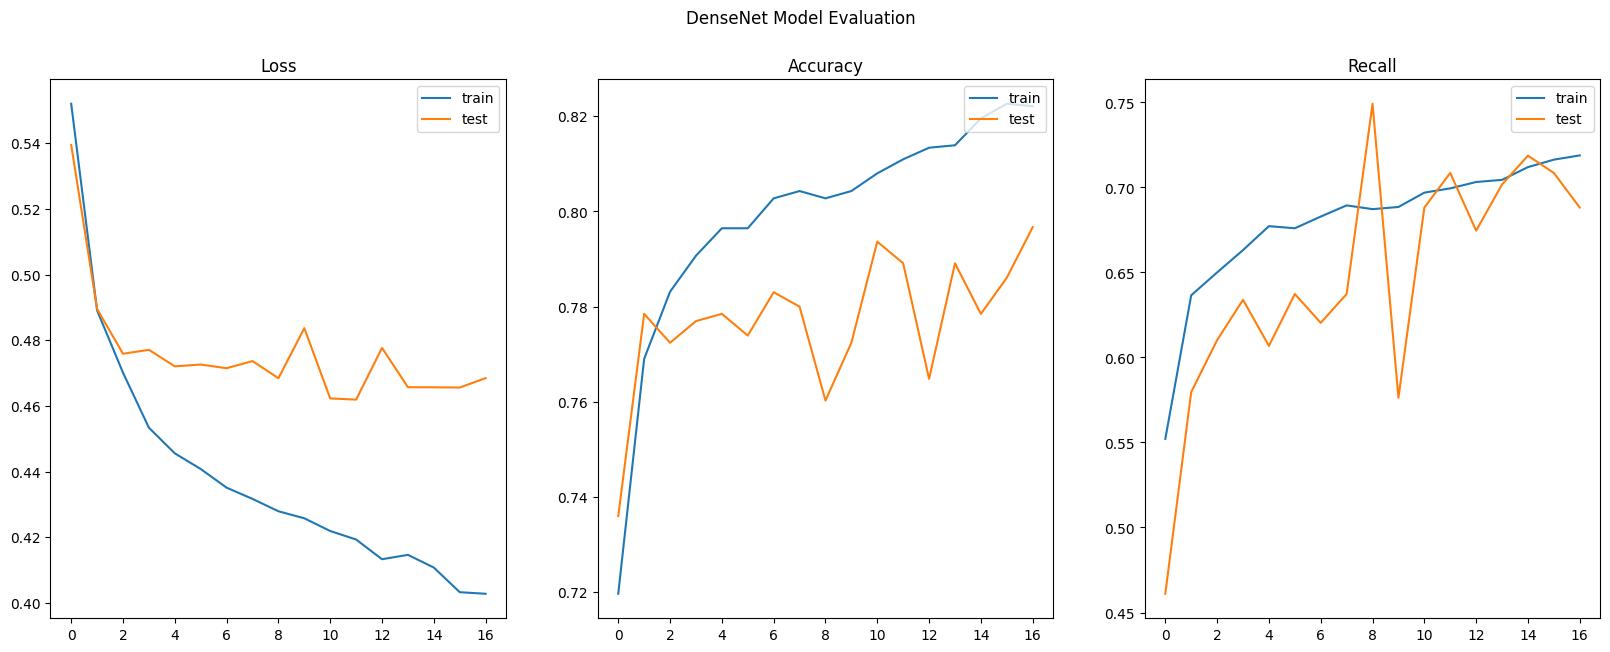

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('DenseNet Model Evaluation')


ax1.set_title('Loss')
ax1.plot(dense_history.history['loss'])
ax1.plot(dense_history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper right')

ax2.set_title('Accuracy')
ax2.plot(dense_history.history['accuracy'])
ax2.plot(dense_history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper right')

ax3.set_title('Recall')
ax3.plot(dense_history.history['recall_1'])
ax3.plot(dense_history.history['val_recall_1'])
ax3.legend(['train', 'test'], loc='upper right')

plt.show()


The DenseNet model exhibits progressive improvements in performance over 20 epochs of training. Initially, the training and validation losses decrease steadily, accompanied by an increase in both training and validation accuracies. However, the rate of improvement diminishes as training progresses, as indicated by the decreasing learning rate. Notably, the model achieves a peak validation accuracy of approximately 79.67% by the end of training. Additionally, the recall metric, which measures the model's ability to correctly identify positive instances, also shows improvement over epochs, indicating the model's enhanced capability in capturing relevant features for the binary classification task. The convergence of training and validation metrics suggests that the model effectively learns from the training data while generalizing well to unseen validation data.

## Testing the Models

Let us define a dictionary where we can store our results of our respective models.

In [142]:
results_dict = {
    'BaseLine' :['accuracy','recall'],
    'CNN': ['accuracy','recall'],
    'DenseNet':['accuracy','recall']
}

### Baseline Model

In [144]:
labels = test_generator.labels
preds = [model.predict() for _ in labels]

binary_preds = [1 if pred >= 0.5 else 0 for pred in preds]

accuracy = sum([1 if pred == label else 0 for pred, label in zip(binary_preds, labels)]) / len(labels)

# Calculate true positives (TP), false negatives (FN), and true negatives (TN)
TP = sum([1 if pred == 1 and label == 1 else 0 for pred, label in zip(binary_preds, labels)])
FN = sum([1 if pred == 0 and label == 1 else 0 for pred, label in zip(binary_preds, labels)])
TN = sum([1 if pred == 0 and label == 0 else 0 for pred, label in zip(binary_preds, labels)])

# Calculate recall
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

In [145]:
print("Test Accuracy:", accuracy)
print("Test Recall:", recall)

Test Accuracy: 0.4920553562275756
Test Recall: 0.4860759493670886


In [146]:
results_dict['BaseLine'][0] = accuracy
results_dict['BaseLine'][1] = recall

### CNN Model

In [134]:
cnn_test_metrics = cnn_model.evaluate(test_generator)

61/61 [==============================] - 11s 183ms/step - loss: 1.0421 - accuracy: 0.7509 - recall_2: 0.6013


In [137]:
print("Test Accuracy:", cnn_test_metrics[1])
print("Test Recall:", cnn_test_metrics[2])

Test Accuracy: 0.7508969902992249
Test Recall: 0.6012658476829529


In [147]:
results_dict['CNN'][0] = cnn_test_metrics[1]
results_dict['CNN'][1] = cnn_test_metrics[2]

### CNN with DenseNet

In [127]:
dense_test_metrics = dense_model.evaluate(test_generator)

61/61 [==============================] - 666s 11s/step - loss: 0.4580 - accuracy: 0.7899 - recall_1: 0.6873


In [138]:
print("Test Accuracy:", dense_test_metrics[1])
print("Test Recall:", dense_test_metrics[2])

Test Accuracy: 0.7898513674736023
Test Recall: 0.6873417496681213


In [148]:
results_dict['DenseNet'][0] = dense_test_metrics[1]
results_dict['DenseNet'][1] = dense_test_metrics[2]

## Results

**Metric Selection**

In our case, recall is crucial for minimizing false negatives and ensuring the sensitive identification of abnormalities. False negatives, where abnormalities go undetected, can lead to delayed diagnosis and treatment, potentially harming patients. High recall ensures that the model effectively captures even subtle signs of abnormality, aiding radiologists in identifying rare anomalies against a background of normal images. By reliably flagging suspicious regions for closer examination, a high-recall model serves as a valuable diagnostic support tool, facilitating timely intervention and potentially improving patient outcomes through early detection and treatment.

Let us visualize the results.

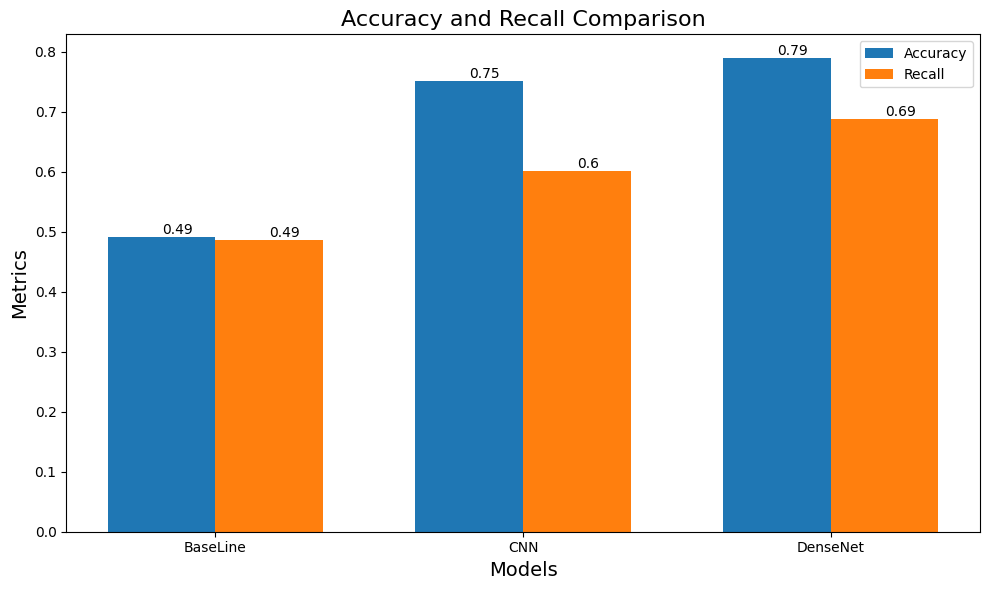

In [151]:
baseline_metrics = results_dict['BaseLine']
cnn_metrics = results_dict['CNN']
densenet_metrics = results_dict['DenseNet']

models = ['BaseLine', 'CNN', 'DenseNet']

accuracy_values = [baseline_metrics[0], cnn_metrics[0], densenet_metrics[0]]

recall_values = [baseline_metrics[1], cnn_metrics[1], densenet_metrics[1]]

plt.figure(figsize=(10, 6))

bar_width = 0.35

index = range(len(models))

bars_accuracy = plt.bar(index, accuracy_values, bar_width, label='Accuracy')

bars_recall = plt.bar([i + bar_width for i in index], recall_values, bar_width, label='Recall')

plt.xlabel('Models', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.title('Accuracy and Recall Comparison', fontsize=16)
plt.xticks([i + bar_width/2 for i in index], models)
plt.legend()

for bars in [bars_accuracy, bars_recall]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()

The outcomes from the three models – BaseLine, CNN and DenseNet – demonstrate levels of performance in terms of accuracy and recall. The BaseLine model shows the accuracy at around 49.21% and a recall of 48.61% indicating its limited ability to correctly classify instances and detect relevant anomalies in radiographs. On the hand the CNN model exhibits a notable improvement with an accuracy of approximately 75.09% and a recall of 60.13% implying better performance in overall classification accuracy and anomaly detection sensitivity. Conversely the DenseNet model surpasses both the BaseLine and CNN models achieving the accuracy of about 78.99% and a recall of 68.73%. This superior performance suggests that the DenseNet architecture effectively captures features in radiographs leading to more precise classification and increased sensitivity to anomalies. In summary the DenseNet model presents results emphasizing the significance of utilizing advanced architectures to attain optimal performance, in anomaly detection tasks involving radiographs.


Additionally, the dataset comprises images with varying specifications and angles, which can pose challenges for model generalization and performance. The variability in image characteristics such as resolution, orientation, and quality across the dataset may have contributed to the lower scores observed, particularly in the BaseLine model. Models trained on heterogeneous datasets with such inconsistencies may struggle to learn robust representations and generalize effectively to unseen data, leading to reduced accuracy and recall. Despite these challenges, the significant performance improvement observed with the CNN and DenseNet models underscores their effectiveness in mitigating the impact of dataset variability through their inherent capacity to learn complex patterns and features from diverse image inputs.

## Future Scope

One potential way to move forward is by standardizing the dataset using data preprocessing methods to ensure consistency in image features. After organizing the data to make image characteristics more uniform and dividing it into sections based on body parts specialized models can be created to identify distinct patterns and irregularities specific to each area. The use of transfer learning alongside existing models can enhance performance leading to precise anomaly detection and improved diagnostic results, in medical imaging. This strategy boosts sensitivity while reducing negatives ultimately improving patient care and clinical decision making in radiology.


The project was originally intended to involve radiographs of all body parts. However due to time constraints during training one specific body part was focused on. Moreover using autoencoders, with CNN initially yielded outcomes leading to the choice of sticking with CNN utilizing more advanced structures.